In [1]:
from opt_einsum import contract
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:0')
torch.cuda.set_device(device)
import numpy as np
from ScalingDimensions import get_scaling_dimensions
from tqdm.auto import tqdm
import pandas as pd

In [2]:
options,params,layers,Ts,logTotals=torch.load('./data/hotrg_gilt_X32.pkl',map_location=device)

In [3]:
T=Ts[20]
M=contract('iIaa->iI',T).reshape(32,32).cdouble()
s,u=torch.linalg.eig(M)# M=u*s@u.t().conj()
assert torch.isclose(M@u,u*s).all()
print(get_scaling_dimensions(s[:64].abs(),scaling=np.exp(2*np.pi)))
scd=torch.round(get_scaling_dimensions(s.abs(),scaling=np.exp(2*np.pi))*8)/8
print(scd)

tensor([-0.0000, 0.1244, 1.0149, 1.1476, 1.1528, 1.6208, 1.6892, 1.7969, 1.8620,
        1.9973, 1.9076, 2.0567, 2.1468, 2.1800, 2.0792, 2.3207, 2.2562, 2.4328,
        2.5216, 2.5092, 2.3592, 2.6072, 2.5779, 2.7212, 2.8704, 2.7979, 3.1323,
        2.8212, 2.7352, 3.2315, 2.9696, 2.9160])
tensor([-0.0000, 0.1250, 1.0000, 1.1250, 1.1250, 1.6250, 1.7500, 1.7500, 1.8750,
        2.0000, 1.8750, 2.0000, 2.1250, 2.1250, 2.1250, 2.3750, 2.2500, 2.3750,
        2.5000, 2.5000, 2.3750, 2.6250, 2.6250, 2.7500, 2.8750, 2.7500, 3.1250,
        2.8750, 2.7500, 3.2500, 3.0000, 2.8750])


In [4]:
from HOTRGZ2 import forward_observable_tensors
from TNModels import Ising2D

In [5]:
from matplotlib import pyplot as plt

  0%|          | 0/20 [00:00<?, ?it/s]

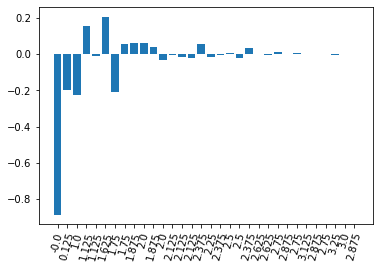

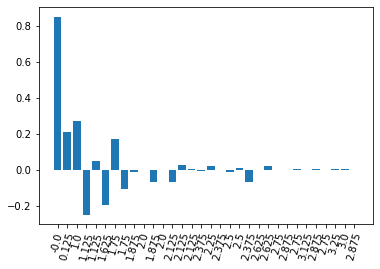

In [6]:
T0_op,checkerboard=Ising2D(params).get_observables()['magnetization']

def apply_to_vacuum(T1):
    v_op=contract('iIab,I->i',T1.cdouble(),u[:,0].reshape(32)).flatten()
    v_op=v_op/v_op.norm()
    return v_op



def show_overlap(v_op):
    overlap=torch.real(u.T.conj()@v_op)
    plt.bar(range(32),(overlap[:32]).cpu().numpy())
    plt.xticks(range(32),scd[:32].cpu().numpy(),rotation=75)
    plt.show()

T,T_op,logTotal=forward_observable_tensors(Ts[0],[T0_op],[(2**10-1,0)],layers[:20],checkerboard=checkerboard,cached_Ts=Ts)
show_overlap(apply_to_vacuum(T_op))
show_overlap(apply_to_vacuum(T))

In [59]:
data=[]
for x in tqdm(np.linspace(0,1,41)):
    intx=int(x*(2**11-1))
    T,T_op,logTotal=forward_observable_tensors(Ts[0],[T0_op],[(0,intx%2**10)],layers[:20],checkerboard=checkerboard,cached_Ts=Ts,user_tqdm=False)
    if intx>=2**10:
        v_op=apply_to_vacuum(T,T_op)
    else:
        v_op=apply_to_vacuum(T_op,T)
    overlap=torch.real(u.T.conj()@v_op)
    overlap=overlap/overlap.norm()
    data.append({'x':x,'overlap':overlap.cpu().numpy()})

  0%|          | 0/41 [00:00<?, ?it/s]

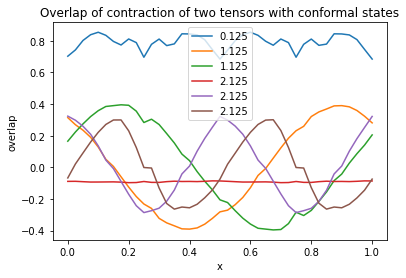

In [63]:
curve=pd.DataFrame(data)
overlaps=np.array(curve['overlap'].tolist())

for i in range(16):
    overlap=overlaps[:,i]#/overlaps[:,1]
    if np.linalg.norm(overlap)>1e-6:
        plt.plot(curve['x'],overlap,label=f'{scd[i]:.3f}')
plt.legend()
plt.title('Overlap of contraction of two tensors with conformal states')
plt.xlabel('x')
plt.ylabel('overlap')
plt.show()